In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly.express as px
import scipy.stats as stats
import pylab 
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from fbprophet import Prophet
import pmdarima as pm
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_excel('Data.xlsx')

#### check for null values
we can see that we have null values for description and customerid, but since we only care about stockcode and date for our timeseries analysis, we can leave them like this

In [3]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### distribution of the numeric data

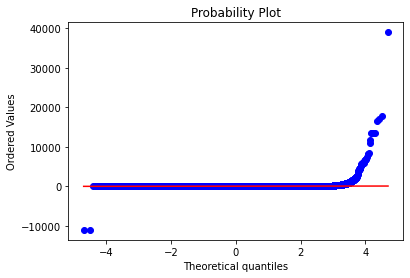

In [4]:
stats.probplot(df['UnitPrice'], dist="norm", plot=pylab)

plt.show()

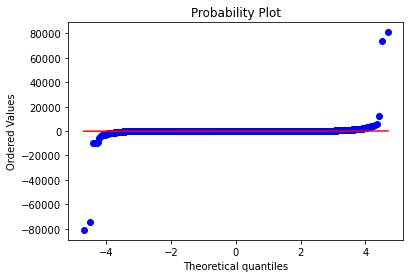

In [5]:
stats.probplot(df['Quantity'], dist="norm", plot=pylab)

plt.show()

### descriptive statistics of the data

In [6]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


### we can see that we have negative quantities which we have to change them to zero

In [7]:
# check the first 200 values
np.unique(df.Quantity)[:200]

array([-80995, -74215,  -9600,  -9360,  -9058,  -5368,  -4830,  -3667,
        -3167,  -3114,  -3100,  -3000,  -2880,  -2834,  -2618,  -2600,
        -2472,  -2376,  -2003,  -2000,  -1930,  -1897,  -1681,  -1671,
        -1560,  -1515,  -1512,  -1510,  -1479,  -1440,  -1430,  -1400,
        -1350,  -1300,  -1296,  -1284,  -1277,  -1206,  -1200,  -1158,
        -1131,  -1128,  -1121,  -1100,  -1092,  -1060,  -1050,  -1000,
         -990,   -975,   -967,   -960,   -939,   -905,   -900,   -864,
         -840,   -828,   -800,   -786,   -756,   -752,   -750,   -741,
         -723,   -720,   -701,   -696,   -690,   -682,   -675,   -674,
         -670,   -664,   -657,   -635,   -624,   -620,   -618,   -600,
         -590,   -576,   -553,   -550,   -541,   -530,   -524,   -504,
         -500,   -484,   -480,   -472,   -468,   -458,   -455,   -450,
         -443,   -434,   -432,   -430,   -428,   -420,   -413,   -408,
         -400,   -398,   -391,   -390,   -384,   -380,   -365,   -360,
      

In [8]:
# change negative values to zero
df['Quantity']=df['Quantity'].apply(lambda x: 0 if x<0 else x)

In [9]:
# check the first 200 values again after the fix
np.unique(df.Quantity)[:200]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132,
       133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 153, 155, 156, 157, 158, 160, 162,
       163, 164, 165, 167, 168, 170, 171, 172, 175, 176, 177, 179, 180,
       181, 183, 184, 186, 188, 192, 193, 196, 197, 198, 199, 20

### Change quantity to zero if we have 'c' in the invoice number because that means cancellation

In [10]:
# we create a seperate column and 1 for if the type of invoice is string else 0
df['c']=df['InvoiceNo'].apply(lambda x: 1 if type(x)==str else 0)

In [11]:
# since we only want invoices with letter C in front and not any other letter we have to specify it
def c_finder(df):
    """
    This function takes dataframe as an argument
    and checks if there is 1 in 'c' column and 
    there is letter 'c' in invoice number column
    and returns 1, else returns 0
    """
    if df['c']==1:
        if 'c' in df['InvoiceNo'].lower():
            return 1
    else:
        return 0

In [12]:
df['c']=df.apply(c_finder,axis=1)

In [13]:
# we can see that if the invoice number has a c then we have 1 in the 'c' column
df.loc[df['c']==1][['c','InvoiceNo']]

,c,InvoiceNo
141,1.0,C536379
154,1.0,C536383
235,1.0,C536391
236,1.0,C536391
237,1.0,C536391
...,...,...
540449,1.0,C581490
541541,1.0,C581499
541715,1.0,C581568
541716,1.0,C581569


In [14]:
# now we check the quantities if there was a cancellation
df.loc[(df['c']==1) & (df['Quantity']!=0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,c


Since we got an empty dataframe it means that if it was cancelled then quantity was 0, so we don't need to set it to 0

### We need to set the index to the invoice date column
Since we are performing timeseries analysis, by having date on the index, we can check for missing dates easier

In [15]:
# we only want year-month-day format so we set our date time like this
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'], format='%y%m%d').dt.date

In [16]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,c
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,0.0


In [17]:
# set date to index
df = df.set_index('InvoiceDate')
df.index = pd.to_datetime(df.index)

In [18]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,c
InvoiceDate,,,,,,,,
2010-12-01,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,0.0
2010-12-01,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,0.0
2010-12-01,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,0.0
2010-12-01,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,0.0
2010-12-01,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,0.0


### check for missing dates

In [19]:
# these are our missing dates in the whole dataset
null_dates=pd.date_range(start = '2010-12-01', end = '2011-12-09' ).difference(df.index)
print(f'number of missing dates : {len(null_dates)}')
print('\t')
print(null_dates)

number of missing dates : 69
	
DatetimeIndex(['2010-12-04', '2010-12-11', '2010-12-18', '2010-12-24',
               '2010-12-25', '2010-12-26', '2010-12-27', '2010-12-28',
               '2010-12-29', '2010-12-30', '2010-12-31', '2011-01-01',
               '2011-01-02', '2011-01-03', '2011-01-08', '2011-01-15',
               '2011-01-22', '2011-01-29', '2011-02-05', '2011-02-12',
               '2011-02-19', '2011-02-26', '2011-03-05', '2011-03-12',
               '2011-03-19', '2011-03-26', '2011-04-02', '2011-04-09',
               '2011-04-16', '2011-04-22', '2011-04-23', '2011-04-24',
               '2011-04-25', '2011-04-29', '2011-04-30', '2011-05-02',
               '2011-05-07', '2011-05-14', '2011-05-21', '2011-05-28',
               '2011-05-30', '2011-06-04', '2011-06-11', '2011-06-18',
               '2011-06-25', '2011-07-02', '2011-07-09', '2011-07-16',
               '2011-07-23', '2011-07-30', '2011-08-06', '2011-08-13',
               '2011-08-20', '2011-08-27', '20

In [20]:
# our dataset date range is 374 days
number_days=pd.date_range(start = '2010-12-01', end = '2011-12-09' )
print(f'number of days for this dataset : {len(number_days)}')

number of days for this dataset : 374


### choosing the best products to perform time series
since we have more than 4000 unique products we need to perform time series on a subset of the products due to the large dataset, thus we will decide which products to choose

In [21]:
# group by every day and every product
date_stock=df.groupby('StockCode').resample('D').sum()
date_stock

Quantity  UnitPrice  CustomerID    c
StockCode    InvoiceDate                                      
10002        2010-12-01         60       1.70     28681.0  0.0
             2010-12-02          1       0.85         0.0  0.0
             2010-12-03          8       4.17     17967.0  0.0
             2010-12-04          0       0.00         0.0  0.0
             2010-12-05          1       0.85     13069.0  0.0
...                            ...        ...         ...  ...
gift_0001_50 2011-06-27          0       0.00         0.0  0.0
             2011-06-28          0       0.00         0.0  0.0
             2011-06-29          0       0.00         0.0  0.0
             2011-06-30          1      41.67         0.0  0.0
m            2010-12-21          1       2.55         0.0  0.0

[1095044 rows x 4 columns]

In [22]:
# unique products
unique_products=pd.unique(df['StockCode'])
print(f'number of unique products : {len(unique_products)}')
print(unique_products)

number of unique products : 4070
['85123A' 71053 '84406B' ... '90214U' '47591b' 23843]


In [23]:
# we loop through the unique products and if the length of their dates matches our dataframe date range then we append
complete=[]
for i in unique_products:
    if len(date_stock.loc[i])==len(number_days):
        complete.append(i)

In [24]:
# now we only have 566 products that have the same date range like our entire datset
print(f'number of products that match our dataframe date range : {len(complete)}')

number of products that match our dataframe date range : 566


In [25]:
def dict_best():
    """
    we create a dictionary and try to count the number of NONZERO quantities
    in the updated unique product list(complete).

    The strategy in here is we want to choose the products that have the least
    amount of ZERO quantity in them.
    """
    BEST=dict()
    for i in complete:
        stock=date_stock.loc[i]['Quantity']
        BEST[i]=np.count_nonzero(stock)
    return BEST

In [26]:
# sort the values of dictionary
BEST=dict(sorted(dict_best().items(), key=lambda item: item[1],reverse=True))

In [27]:
# we can see that these are our products that have the least amount of ZERO quantities in them everyday
BEST

{'85123A': 305,
 '85099B': 301,
 22423: 301,
 84879: 300,
 20725: 298,
 21212: 298,
 22457: 297,
 22960: 295,
 22197: 294,
 22666: 294,
 20728: 293,
 82482: 292,
 22384: 292,
 20727: 292,
 22727: 290,
 22178: 290,
 21931: 289,
 22697: 289,
 22386: 288,
 22077: 288,
 20726: 287,
 22383: 287,
 22961: 286,
 22411: 286,
 20724: 286,
 '85099C': 285,
 22355: 285,
 22699: 283,
 20914: 282,
 21754: 281,
 22629: 281,
 21790: 281,
 22728: 279,
 21929: 279,
 22630: 279,
 21175: 278,
 21977: 277,
 20712: 277,
 22558: 276,
 'POST': 275,
 84946: 275,
 20719: 275,
 21232: 272,
 22659: 270,
 21731: 270,
 22139: 270,
 22356: 269,
 22326: 268,
 20723: 268,
 22907: 268,
 21928: 268,
 84991: 267,
 21213: 267,
 22662: 264,
 82580: 264,
 22554: 264,
 22379: 263,
 22969: 262,
 21755: 261,
 82484: 260,
 22467: 260,
 22469: 259,
 20685: 259,
 22328: 259,
 84692: 259,
 22219: 258,
 22083: 255,
 84380: 255,
 21930: 255,
 48187: 254,
 22551: 253,
 82486: 252,
 84378: 251,
 22726: 250,
 79321: 250,
 22367: 249,
 2

In [28]:
final_products=list(BEST.keys())[:20]

### find product description of top 20 final products

In [29]:
for i in final_products:
    print(i,':',df.loc[df['StockCode']==i]['Description'].iloc[0])

85123A : WHITE HANGING HEART T-LIGHT HOLDER
85099B : JUMBO BAG RED RETROSPOT
22423 : REGENCY CAKESTAND 3 TIER
84879 : ASSORTED COLOUR BIRD ORNAMENT
20725 : LUNCH BAG RED RETROSPOT
21212 : PACK OF 72 RETROSPOT CAKE CASES
22457 : NATURAL SLATE HEART CHALKBOARD 
22960 : JAM MAKING SET WITH JARS
22197 : SMALL POPCORN HOLDER
22666 : RECIPE BOX PANTRY YELLOW DESIGN
20728 : LUNCH BAG CARS BLUE
82482 : WOODEN PICTURE FRAME WHITE FINISH
22384 : LUNCH BAG PINK POLKADOT
20727 : LUNCH BAG  BLACK SKULL.
22727 : ALARM CLOCK BAKELIKE RED 
22178 : VICTORIAN GLASS HANGING T-LIGHT
21931 : JUMBO STORAGE BAG SUKI
22697 : GREEN REGENCY TEACUP AND SAUCER
22386 : JUMBO BAG PINK POLKADOT
22077 : 6 RIBBONS RUSTIC CHARM


# TIME SERIES ANALYSIS
Due to having many products, I will be doing one manual arima model and one auto arima model for a random product where I will showcase the methods that are needed to do manual and auto arima.
<br>
The main Time Series models for our products will be performed by auto Arima and Prophet.

### manual arima

##### product -  85099B : JUMBO BAG RED RETROSPOT

In [30]:
JUMBO_BAG=date_stock.loc['85099B'][['Quantity']]

# set the frequency to daily
JUMBO_BAG=JUMBO_BAG.asfreq('D')

#train set
train=JUMBO_BAG.loc['2010-12-01':'2011-09-30']

#test set
test=JUMBO_BAG.loc['2011-10-01':'2011-12-09']

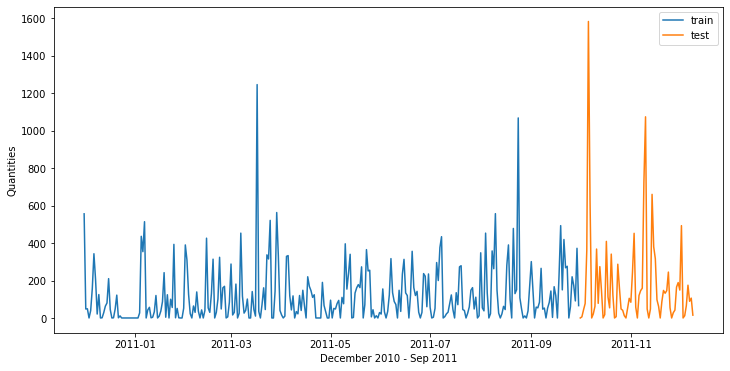

In [31]:
plt.figure(figsize=(12,6))
plt.plot(train,label='train')
plt.plot(test,label='test')
plt.xlabel('December 2010 - Sep 2011')
plt.ylabel('Quantities')
plt.legend(loc='best')
plt.show()

In [32]:
# calculate daily mean and std of the data to see if they are alligned with the main data
rolling_mean=train.rolling(window=2).mean()
rolling_std=train.rolling(window=2).std()

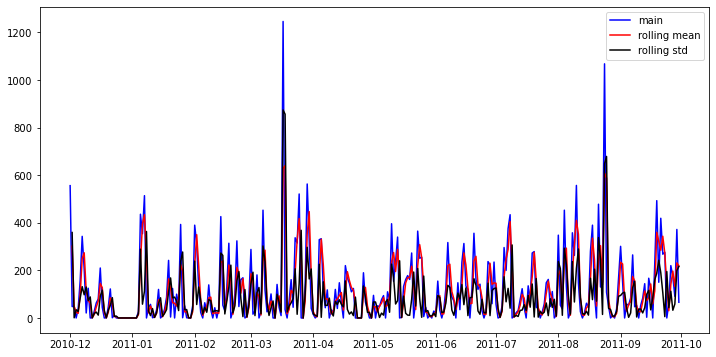

In [33]:
plt.figure(figsize=(12,6))

plt.plot(train,color='blue',label='main')
plt.plot(rolling_mean,color='red',label='rolling mean')
plt.plot(rolling_std,color='black',label='rolling std')
plt.legend(loc='best')
plt.show()

In [34]:
# perform adfuller test for stationary, the null value is that data is not stationary
# since we got a lower p-value than 0.05, we can reject null hypothesis and say our data is stationary
adfuller(train['Quantity'],autolag='AIC')[1]

3.4096696881931073e-06

In [35]:
def best_pq():
    """
    This function finds the best p and q pairs
    with the lowest aic and bic
    """
    order_aic_bic = []

    # Loop over p values from 0-2
    for p in range(3):
        # Loop over q values from 0-2
        for q in range(3):
            # Create and fit ARMA(p, q) model
            model = sm.tsa.ARIMA(train, order=(p, 0, q))
            results = model.fit()

            # Append order and results tuple
            order_aic_bic.append((p, q, results.aic, results.bic))
    order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'AIC', 'BIC'])

    # Print order_df in order of increasing AIC
    print(order_df.sort_values('AIC'))

    # Print order_df in order of increasing BIC
    print(order_df.sort_values('BIC'))

In [36]:
best_pq()

   p  q          AIC          BIC
8  2  2  3908.698729  3931.000895
1  0  1  3929.846882  3940.997965
3  1  0  3930.671613  3941.822696
2  0  2  3931.243380  3946.111491
6  2  0  3931.308947  3946.177058
4  1  1  3931.316245  3946.184356
5  1  2  3932.897158  3951.482296
7  2  1  3932.910859  3951.495998
0  0  0  3935.229438  3942.663493
   p  q          AIC          BIC
8  2  2  3908.698729  3931.000895
1  0  1  3929.846882  3940.997965
3  1  0  3930.671613  3941.822696
0  0  0  3935.229438  3942.663493
2  0  2  3931.243380  3946.111491
6  2  0  3931.308947  3946.177058
4  1  1  3931.316245  3946.184356
5  1  2  3932.897158  3951.482296
7  2  1  3932.910859  3951.495998


we can see that having a p and q of 2 will give us the lowest aic and bic

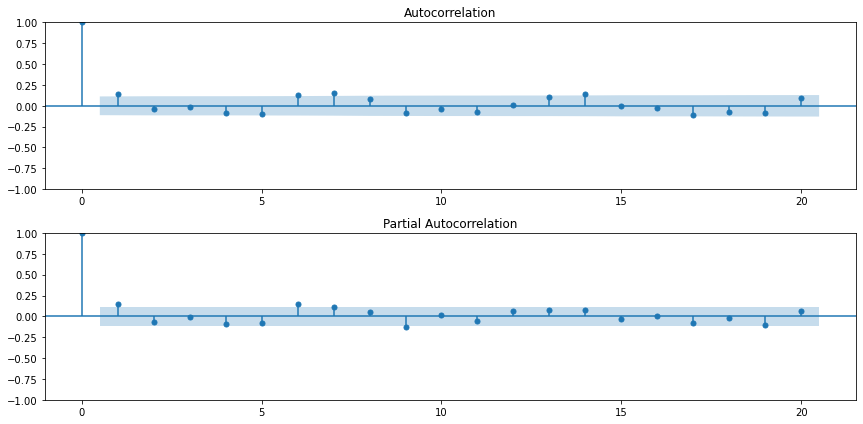

In [37]:
# plot acf and pacf to confirm p and q of 2 is a correct answer
fig, ax = plt.subplots(2,1, figsize=(12, 6))
plot_acf(train,lags=20,ax=ax[0])
plot_pacf(train,lags=20,method='ols',ax=ax[1])
plt.tight_layout()
plt.show()

we can see that 2 is the right answer for both p and q

In [38]:
# create the model of p and q of 2
model_arima=sm.tsa.ARIMA(train, order=(2,0,2))

# fit the model
model_arima_fit=model_arima.fit()

# forecast the model for the amount of days in the test data
fcast1= model_arima_fit.forecast(len(test))

In [39]:
# create a pandas series for the forecast
fcast1=pd.Series(fcast1,index=test.index)

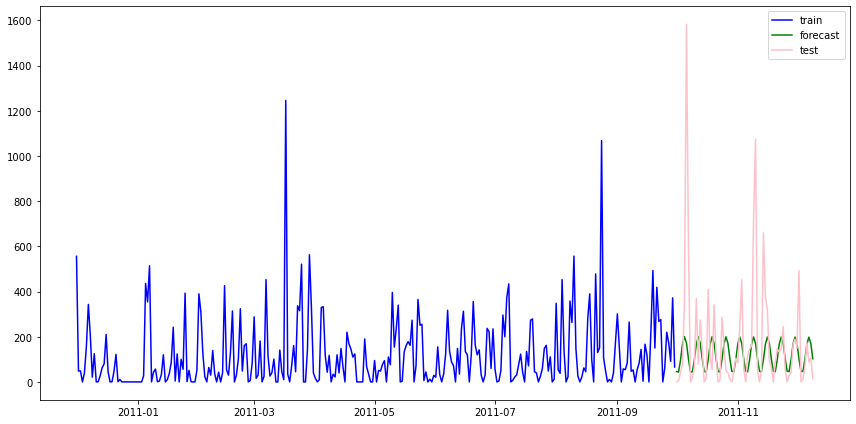

In [40]:
fig, ax=plt.subplots(figsize=(12,6))
plt.plot(train,color='blue',label='train')
plt.plot(fcast1,color='green',label='forecast')
plt.plot(test,color='pink',label='test')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [41]:
# mean square error of this model
mean_squared_error(test.values,fcast1.values,squared=False)

250.7452519814982

### auto arima

In [42]:
# making an auto arima model and by having m=7 it means that we are doing daily
auto_arima=pm.auto_arima(train,m=7,stationary=True)

#forecasting
fcast2=auto_arima.predict(len(test))

#making series of a forecast
fcast2=pd.Series(fcast2,index=test.index)


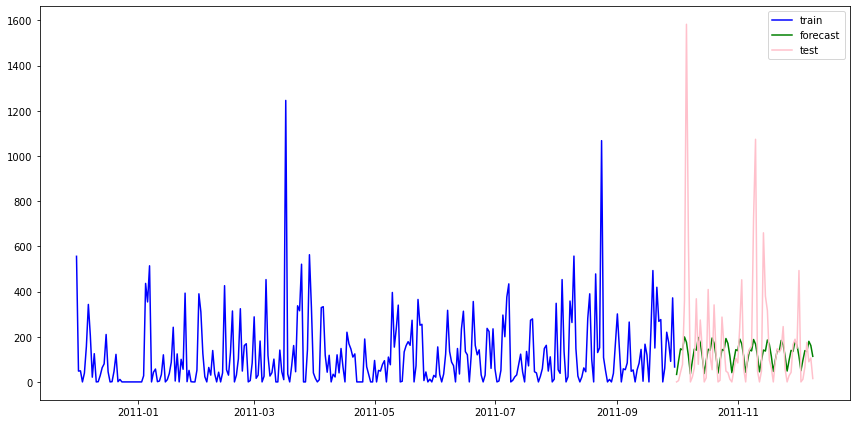

In [43]:
fig, ax=plt.subplots(figsize=(12,6))
plt.plot(train,color='blue',label='train')
plt.plot(fcast2,color='green',label='forecast')
plt.plot(test,color='pink',label='test')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [44]:
# mean squarred error of the auto arima
mean_squared_error(test.values,fcast2.values,squared=False)

249.72362518193057

we can see our auto arima had slightly less error as manual arima

## Time Series for top 20 products

In [45]:
final_products

['85123A',
 '85099B',
 22423,
 84879,
 20725,
 21212,
 22457,
 22960,
 22197,
 22666,
 20728,
 82482,
 22384,
 20727,
 22727,
 22178,
 21931,
 22697,
 22386,
 22077]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.33121
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       621.837   1.97329e-06       88.0297       0.511       0.511      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107        621.84   1.43026e-05       97.9312   1.436e-07       0.001      168  LS failed, Hessian reset 
     145       621.841   3.19649e-08       100.859      0.3685       0.825      222   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


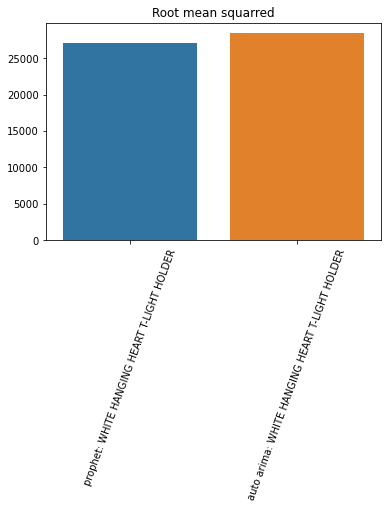

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -10.5195
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        509.28    0.00155145       97.9436      0.6383      0.6383      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       509.466   0.000513219       77.8516   4.412e-06       0.001      260  LS failed, Hessian reset 
     195       509.537   0.000322816       95.1451    3.26e-06       0.001      325  LS failed, Hessian reset 
     199       509.553   7.61112e-05       92.3865           1           1      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       509.561   4.12563e-07        113.75           1           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     360       509.601    1.2429e-08       100.465      0.2932           1      526   
Optimization terminat

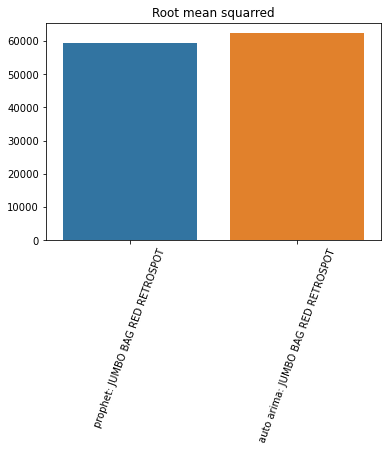

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.77106
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       505.479   1.61899e-08       71.5866      0.1927           1      138   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


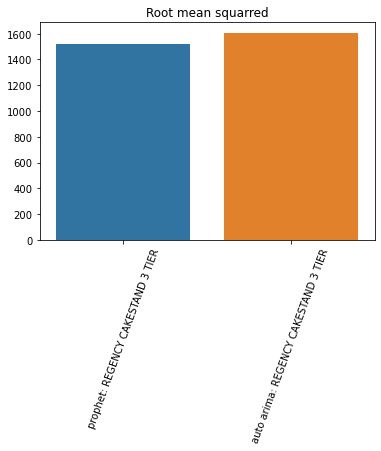

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.71114
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       699.718   0.000137986       81.7185           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       699.743    8.8587e-07       99.8078           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       699.743   6.08427e-09       77.0854      0.1785      0.1785      264   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


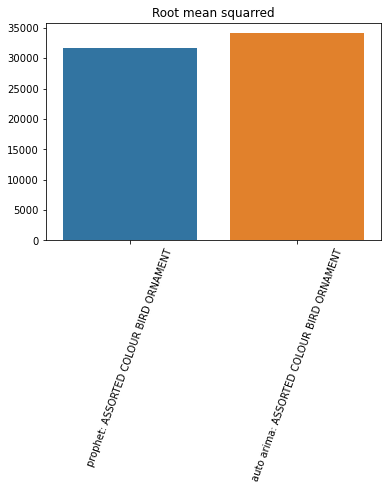

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.83984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       452.893    9.8368e-07       75.1589       0.564       0.564      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       452.894    2.7062e-07       88.1341    2.67e-09       0.001      248  LS failed, Hessian reset 
     172       452.894   4.21284e-09       82.5291      0.1158      0.1158      265   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


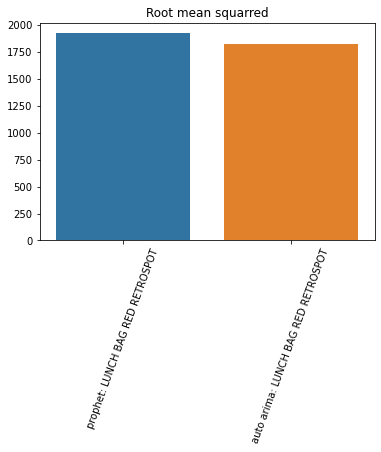

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.49045
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       503.188   0.000786665       101.391   8.146e-06       0.001      127  LS failed, Hessian reset 
      99       503.237   2.99394e-05       100.799      0.7699      0.7699      151   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144        503.24   6.35725e-09       73.4926      0.1125      0.1125      207   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


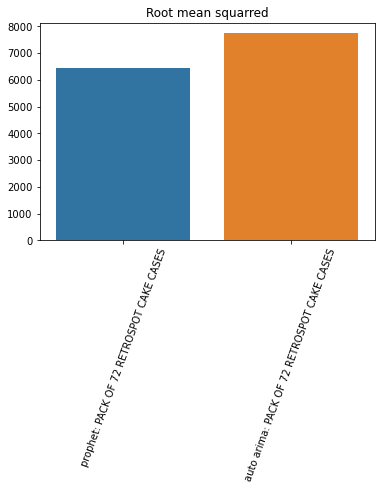

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.82686
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       460.911   2.44109e-07       99.4859      0.5759      0.5759      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       460.911   6.47044e-09       96.9711      0.4837      0.4837      142   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


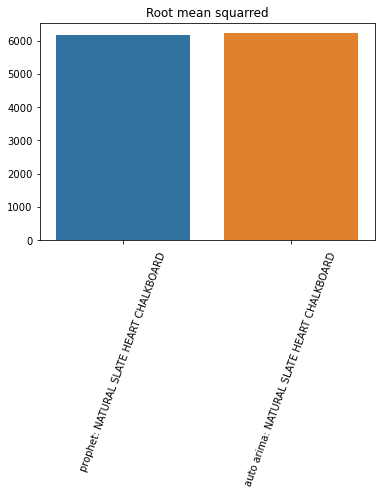

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.32985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        497.25   1.32912e-06        79.082      0.9599      0.9599      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       497.258   1.48539e-05       87.9925   1.823e-07       0.001      249  LS failed, Hessian reset 
     179       497.258   2.82005e-08       77.1348      0.2712           1      285   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


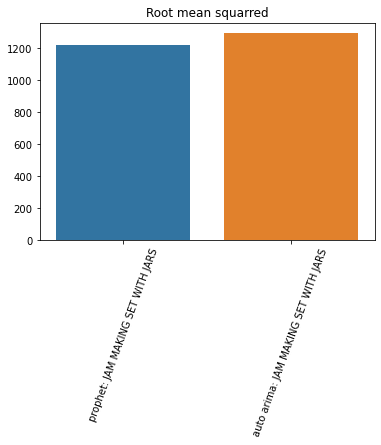

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.80152
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       663.552   0.000406728       86.7554   3.833e-06       0.001      142  LS failed, Hessian reset 
      99        663.62    0.00014505       95.1745           1           1      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       663.714   0.000209084         98.86   2.052e-06       0.001      208  LS failed, Hessian reset 
     184       663.793   2.42421e-08       94.6247      0.1814           1      297   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


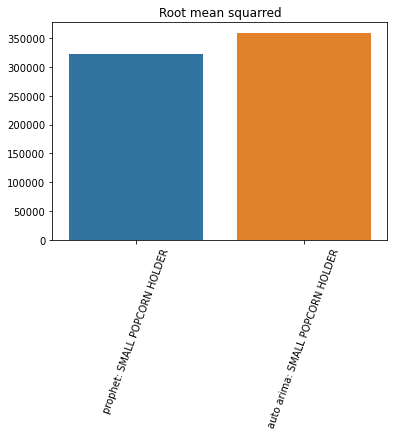

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.93571
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       639.182   4.76353e-06       74.1802      0.2102      0.2102      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       639.195   9.47762e-05       89.5698   1.184e-06       0.001      228  LS failed, Hessian reset 
     199       639.208   2.49596e-06       61.5605           1           1      300   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245       639.208   3.86148e-08       78.6957      0.4015      0.4015      361   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


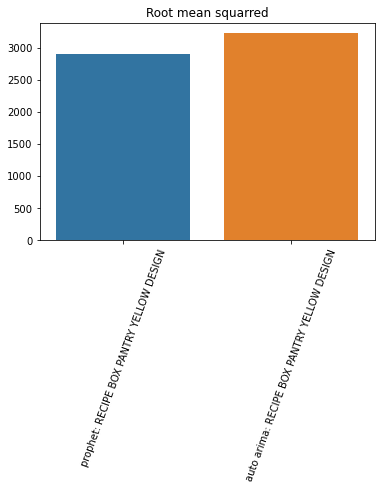

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.90182
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        478.23    2.0429e-07       79.7483      0.7475      0.7475      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119        478.23   1.02747e-08       85.1917      0.2692           1      155   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


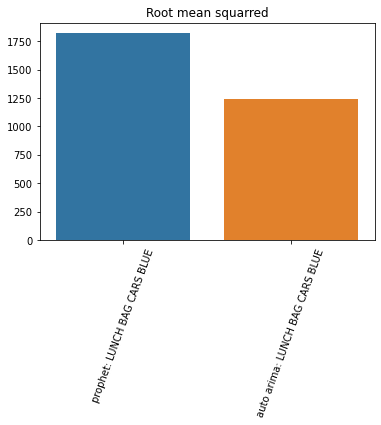

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.7316
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       555.695   4.43957e-05       101.414           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        556.02   1.16836e-07       94.3401      0.7902      0.7902      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206        556.02   7.96624e-09       90.3615       0.354       0.354      260   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


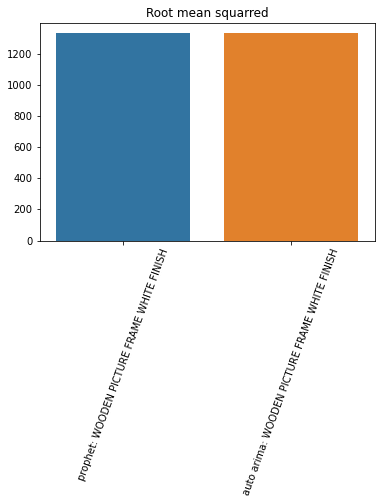

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.67063
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       469.411    7.0299e-07       77.2939   8.501e-09       0.001      175  LS failed, Hessian reset 
      99       469.411   2.53898e-07       60.8145           1           1      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       469.411   2.40163e-08       69.2846           1           1      195   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


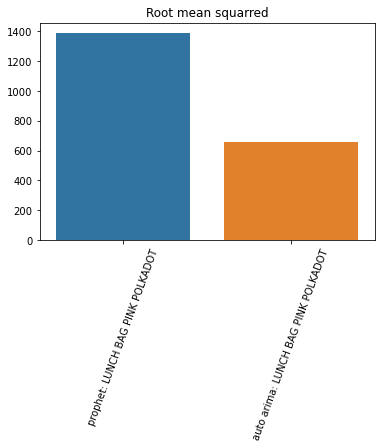

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -18.7365
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        478.43   0.000114731       71.3494           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       478.467   0.000154546       106.326    1.47e-06       0.001      251  LS failed, Hessian reset 
     199       478.481   2.89242e-07       87.6281      0.1839           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       478.482   1.36024e-08       93.9496      0.3271           1      348   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


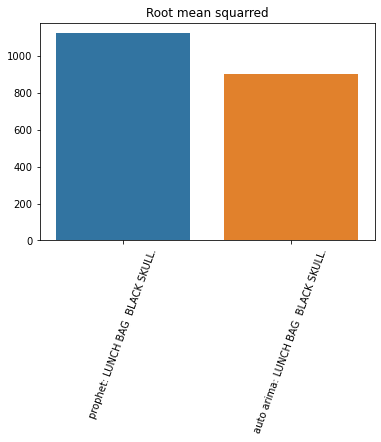

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.2013
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       630.639   0.000176809       63.0261   5.864e-06       0.001      120  LS failed, Hessian reset 
      99       630.653   1.53697e-05       89.8916        0.42       0.042      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139        630.69   1.22402e-05       58.9638   1.554e-07       0.001      260  LS failed, Hessian reset 
     179       630.691   3.45853e-07       43.3667    5.45e-09       0.001      343  LS failed, Hessian reset 
     184       630.691   5.11143e-09       52.0866     0.01035           1      354   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


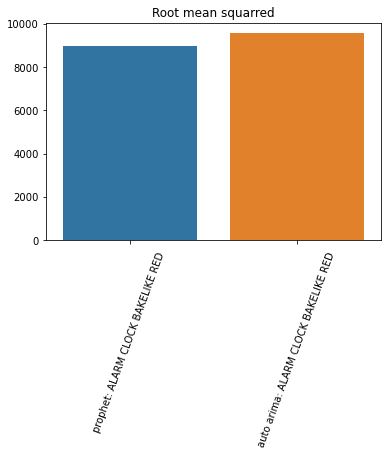

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.9895
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       370.072   1.42337e-06       71.8211   1.688e-08       0.001      177  LS failed, Hessian reset 
      99       370.072   3.73856e-07       55.2989      0.3178           1      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       370.072   2.66584e-08       57.4811       1.004      0.1004      196   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


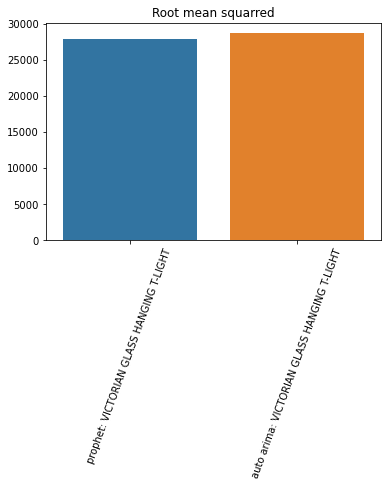

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.80101
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       364.148   2.85921e-06       85.3342      0.8254      0.8254      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       364.148   4.95302e-06       104.465   4.842e-08       0.001      197  LS failed, Hessian reset 
     146       364.149    5.6004e-09       77.9713      0.1296      0.1296      226   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


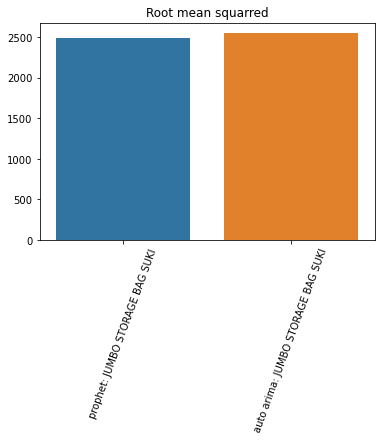

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.02917
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       449.369   7.65501e-07       96.3202      0.3173      0.3173      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       449.369    4.8088e-09       96.9847      0.2874      0.2874      150   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


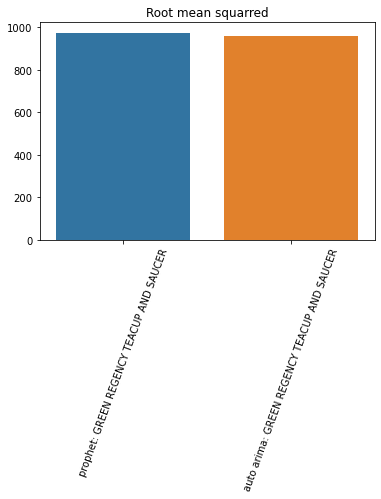

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.7232
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         564.5   1.37142e-07       99.0746      0.5357      0.5357      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       564.501   1.24547e-08       81.7913      0.2097           1      162   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


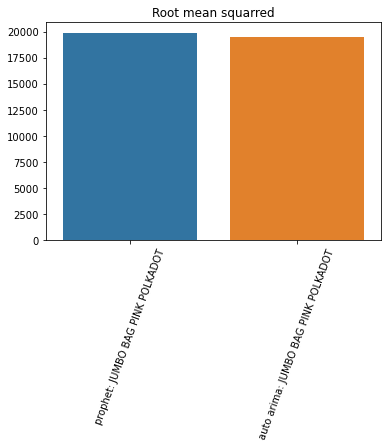

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.2781
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47        460.34   5.81515e-05       68.0302    9.15e-07       0.001       98  LS failed, Hessian reset 
      99       460.367    0.00025055        73.643      0.1841           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       460.382   1.16433e-06       62.6193   2.587e-08       0.001      237  LS failed, Hessian reset 
     180       460.383   3.50288e-08       53.4412      0.0641           1      326   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


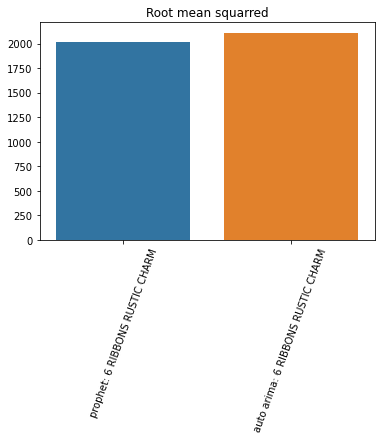

In [46]:
pred_data=pd.DataFrame()
error=pd.DataFrame()
def model_build():
    """
    This function builds and fits
    both prophet and auto arima models
    """
    
    for i in final_products:
        errors=[]
        names=[]
        
        data=date_stock.loc[i][['Quantity']]
        
        # find the unique name of each product
        name=df.loc[df['StockCode']==i]['Description'].iloc[0]
        
        # set the frequency to daily
        data=data.asfreq('D')

        #train set
        train=data.loc['2010-12-01':'2011-09-30']

        #test set
        test=data.loc['2011-10-01':'2011-12-09']
        
        pred_data[name]=test.reset_index()['Quantity']
        
        # create and fit prophet model
        model=Prophet(interval_width=0.95,daily_seasonality=True)

        train1=train.copy()
        train1.reset_index(inplace=True)
        train1.columns=['ds','y']
        model.fit(train1)

        index=pd.DataFrame(test.index)
        index.columns=['ds']
        index['ds']=pd.to_datetime(index['ds'])

        fcasts=model.predict(index)
        fcasts_yhat=pd.Series(fcasts['yhat'].values)
        pred_data[f'prophet {name}']=fcasts_yhat
        
        
        #pickle the prophet models
        with open(f'/Users/raminstad/Downloads/Data Scientist Test/pickle_models/{name}', 'wb') as files:
            pickle.dump(model, files)
        
        
        # create and fit auto arima
        auto_arima=pm.auto_arima(train,m=7,stationary=True)


        fcast2=auto_arima.predict(len(test))


        fcast2=pd.Series(fcast2)

        pred_data[f'auto_arima {name}']=fcast2
        
        #errors
        proph_err=mean_squared_error(test['Quantity'].values,fcasts_yhat.values)
        auto_ar_err=mean_squared_error(test['Quantity'].values,fcast2.values)
        
        #plot errors
        errors.append(proph_err)
        errors.append(auto_ar_err)
        names.append(f'prophet: {name}')
        names.append(f'auto arima: {name}')
        sns.barplot(y=errors,x=names)
        plt.xticks(rotation=70)
        plt.title('Root mean squarred')
        plt.show()
        
        
model_build()
pred_data.set_index(test.index,inplace=True)

In [47]:
# prediction of the test dat with the test data
# from 2011-10-01 to 2011-12-09
pred_data.to_csv('test_predication.csv')
pred_data

,WHITE HANGING HEART T-LIGHT HOLDER,prophet WHITE HANGING HEART T-LIGHT HOLDER,auto_arima WHITE HANGING HEART T-LIGHT HOLDER,JUMBO BAG RED RETROSPOT,prophet JUMBO BAG RED RETROSPOT,auto_arima JUMBO BAG RED RETROSPOT,REGENCY CAKESTAND 3 TIER,prophet REGENCY CAKESTAND 3 TIER,auto_arima REGENCY CAKESTAND 3 TIER,ASSORTED COLOUR BIRD ORNAMENT,...,auto_arima JUMBO STORAGE BAG SUKI,GREEN REGENCY TEACUP AND SAUCER,prophet GREEN REGENCY TEACUP AND SAUCER,auto_arima GREEN REGENCY TEACUP AND SAUCER,JUMBO BAG PINK POLKADOT,prophet JUMBO BAG PINK POLKADOT,auto_arima JUMBO BAG PINK POLKADOT,6 RIBBONS RUSTIC CHARM,prophet 6 RIBBONS RUSTIC CHARM,auto_arima 6 RIBBONS RUSTIC CHARM
InvoiceDate,,,,,,,,,,,,,,,,,,,,,
2011-10-01,0,-26.536573,112.664474,0,33.740564,33.155807,0,-13.975710,17.371019,0,...,8.619170,0,4.857457,3.682803,0,29.322234,26.259989,0,6.980645,4.904363
2011-10-02,21,33.649813,112.664474,6,90.292285,92.867286,5,5.055904,16.054804,24,...,31.291661,6,17.751321,17.005037,3,54.721001,51.447139,3,20.447321,19.110329
2011-10-03,23,97.789752,112.664474,43,167.658118,146.738744,26,19.548460,19.805922,72,...,31.009197,6,26.014738,22.508982,2,85.026207,53.846980,4,38.195704,36.705766
2011-10-04,20,177.069070,112.664474,77,206.972673,141.358122,47,25.801077,29.494985,84,...,52.086544,22,30.232347,26.391082,64,96.961440,91.675824,52,31.881204,21.944510
2011-10-05,49,72.657335,112.664474,361,213.712047,199.123792,228,32.488212,26.075995,91,...,65.530938,204,25.454959,22.265846,212,100.059449,101.526228,86,34.885206,30.147571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-05,298,87.003320,112.664474,66,181.422146,138.702571,36,14.404703,38.617888,133,...,31.900754,159,28.044622,21.777810,28,97.095239,56.681830,97,42.646114,34.800129
2011-12-06,39,166.282638,112.664474,175,220.736701,134.489935,160,20.657320,38.617892,240,...,47.800044,7,32.262231,24.280345,23,109.030472,63.551793,24,36.331614,22.149214
2011-12-07,200,61.870903,112.664474,89,227.476076,179.716259,130,27.344455,38.617895,256,...,57.941563,40,27.484843,22.925872,33,112.128481,64.233071,6,39.335616,29.179525


In [48]:
def plot_models():
    """
    This function plots the models for each product
    """
    for i in final_products:
        data=date_stock.loc[i][['Quantity']]
        
        name=df.loc[df['StockCode']==i]['Description'].iloc[0]
        # set the frequency to daily
        data=data.asfreq('D')

        #train set
        train=data.loc['2010-12-01':'2011-09-30']

        #test set
        test=data.loc['2011-10-01':'2011-12-09']

        fig, ax=plt.subplots(figsize=(12,6))
        plt.plot(train,color='blue',label='train')
        plt.plot(pred_data[f'auto_arima {name}'],color='orange',label='auto arima')
        plt.plot(pred_data[f'prophet {name}'],color='green',label='prophet')
        plt.plot(test,color='red',label='test')
        plt.legend(loc='best')
        plt.title(name)
        plt.tight_layout()
        plt.show()

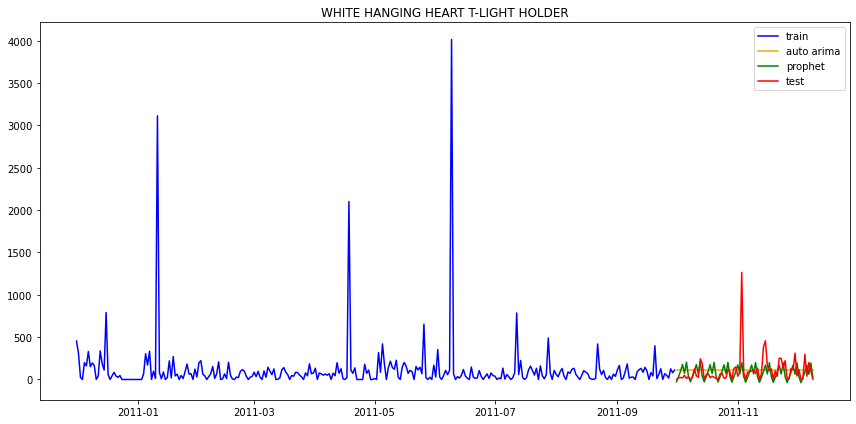

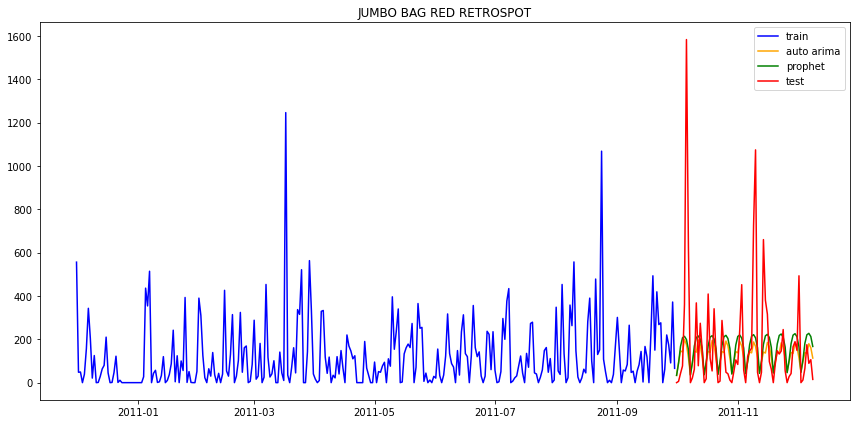

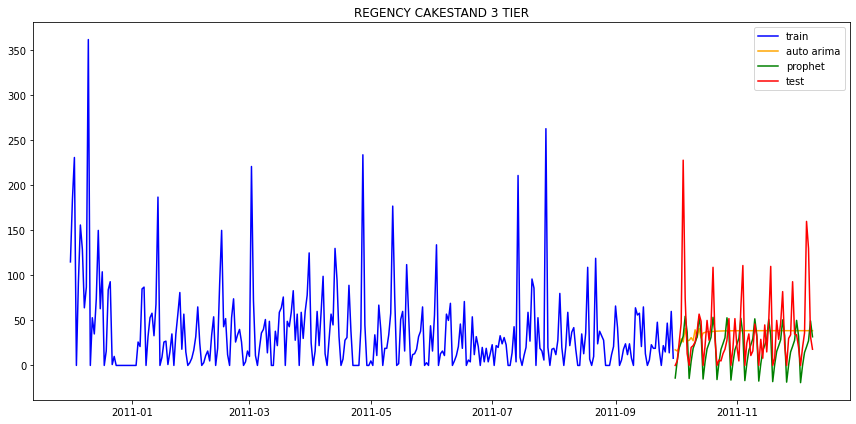

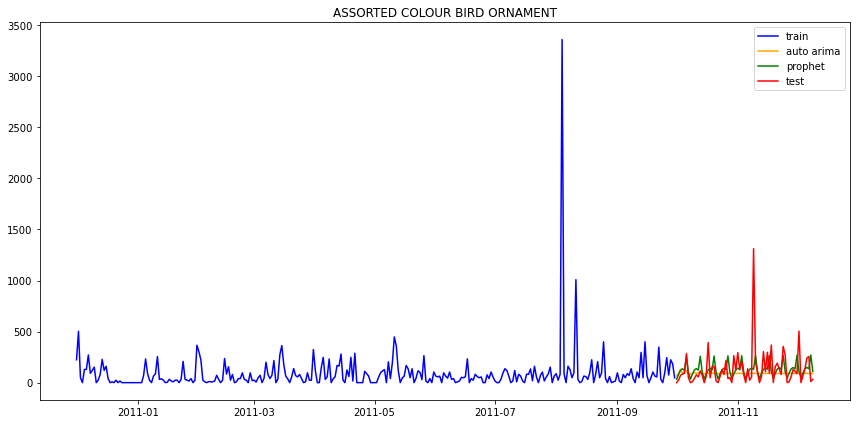

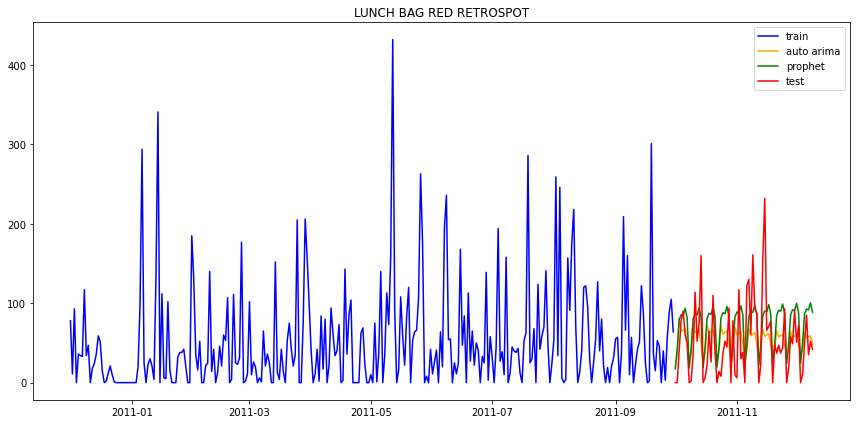

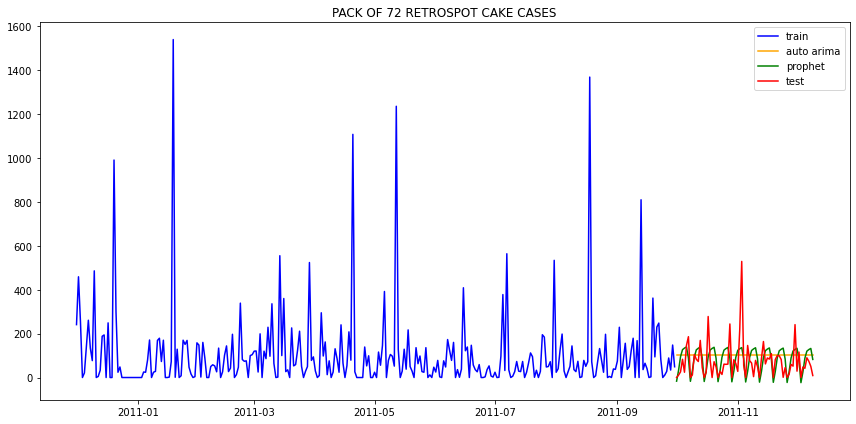

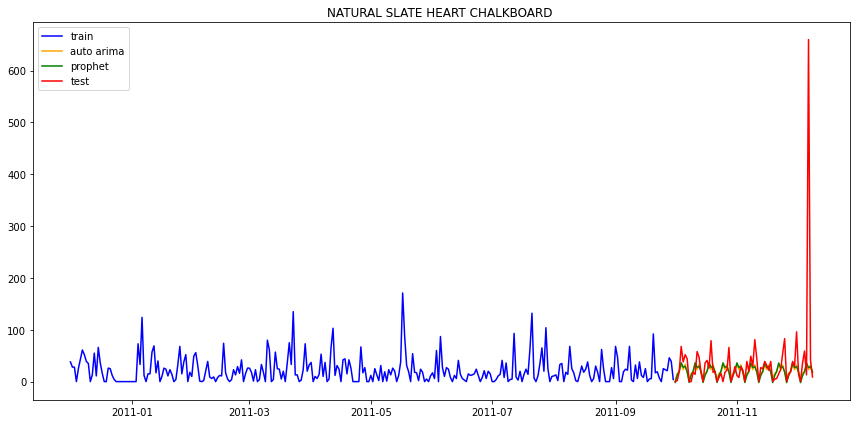

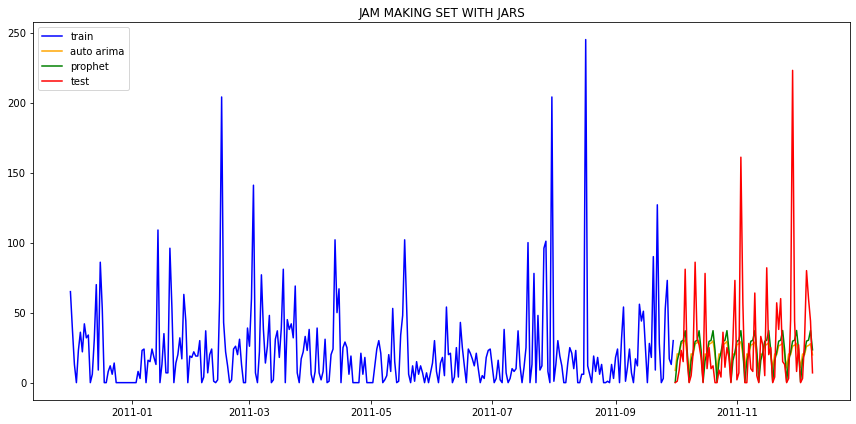

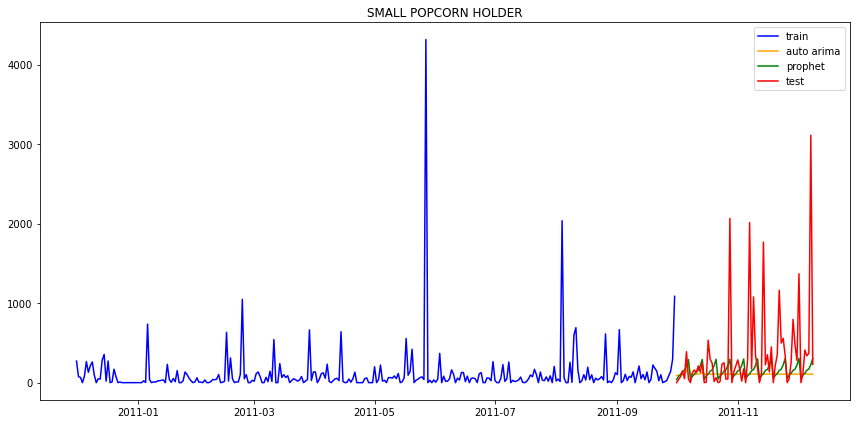

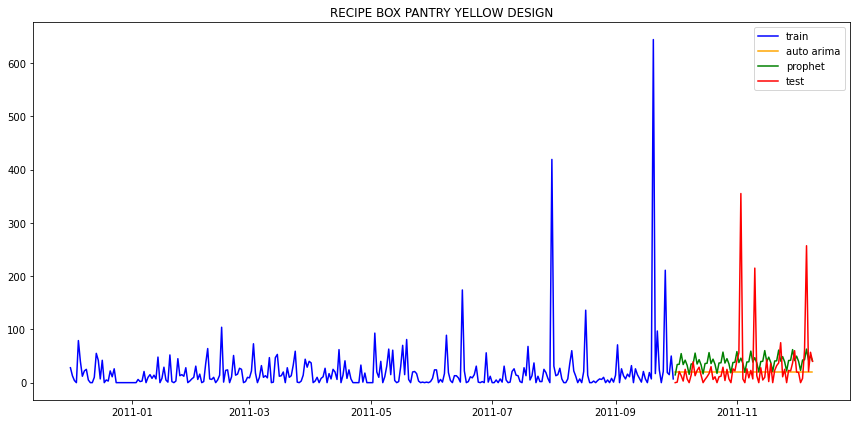

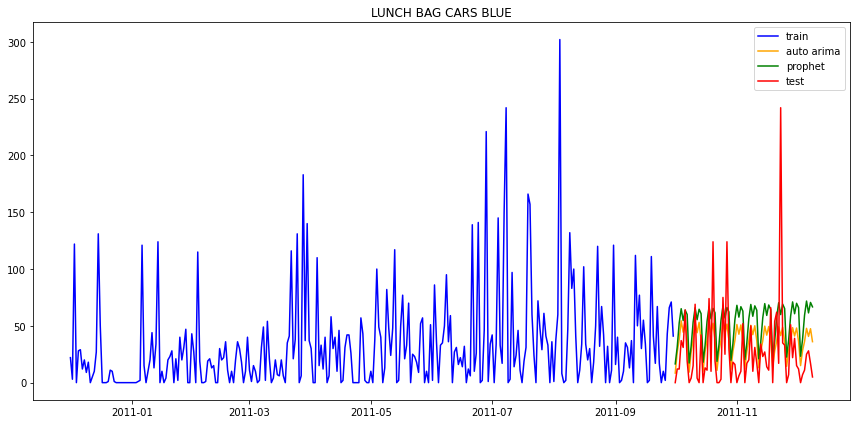

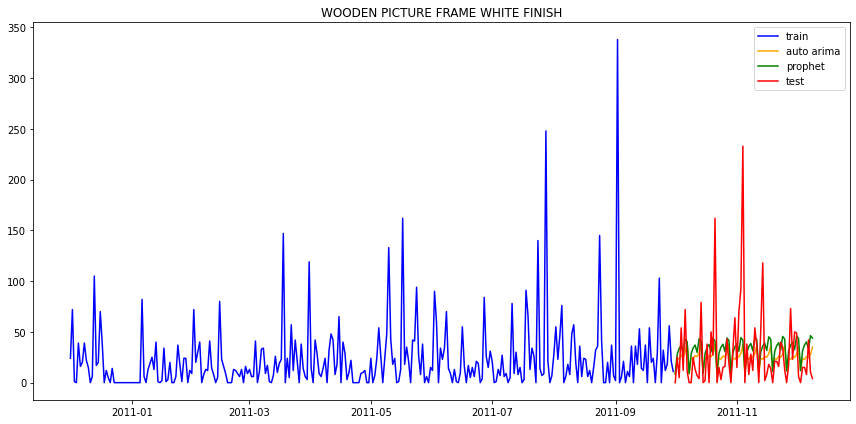

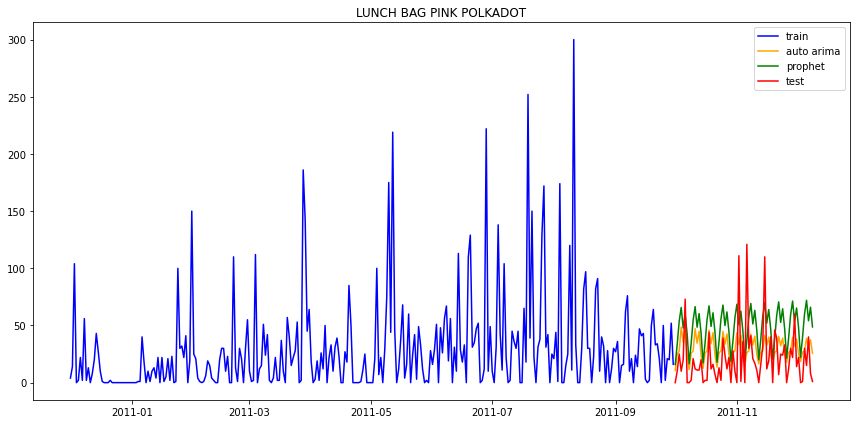

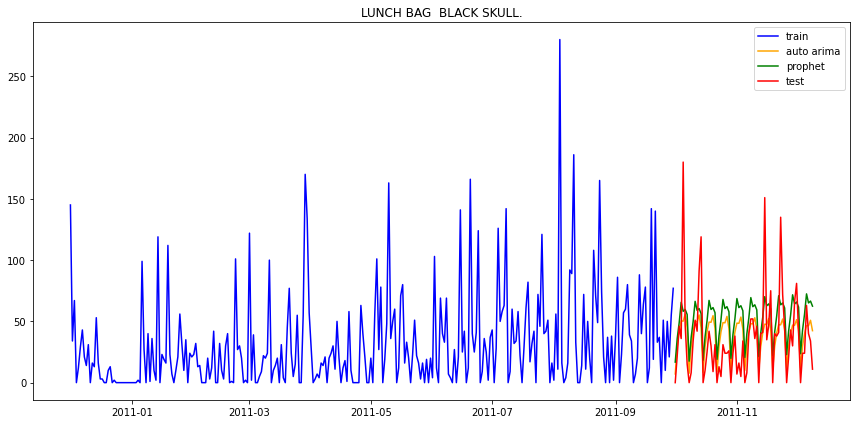

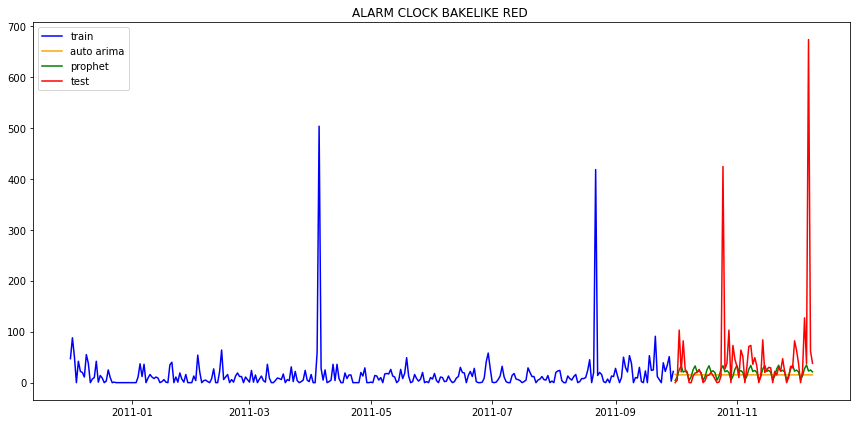

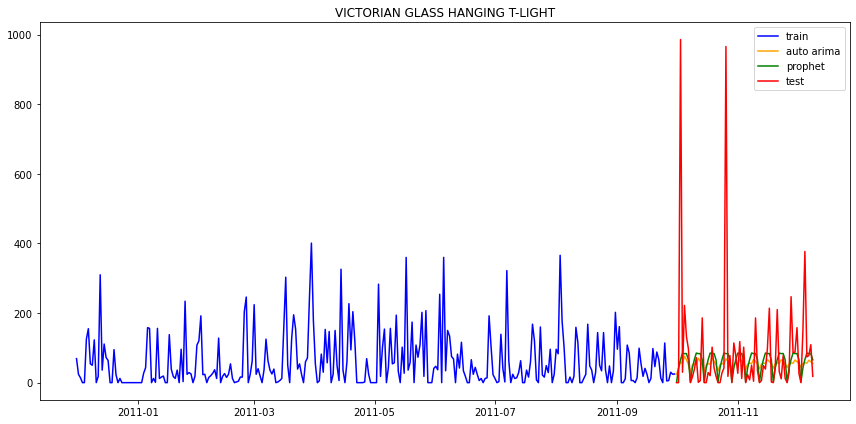

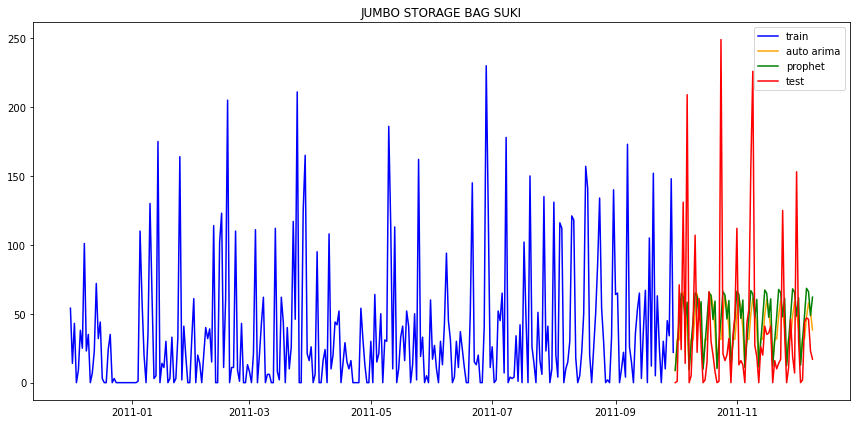

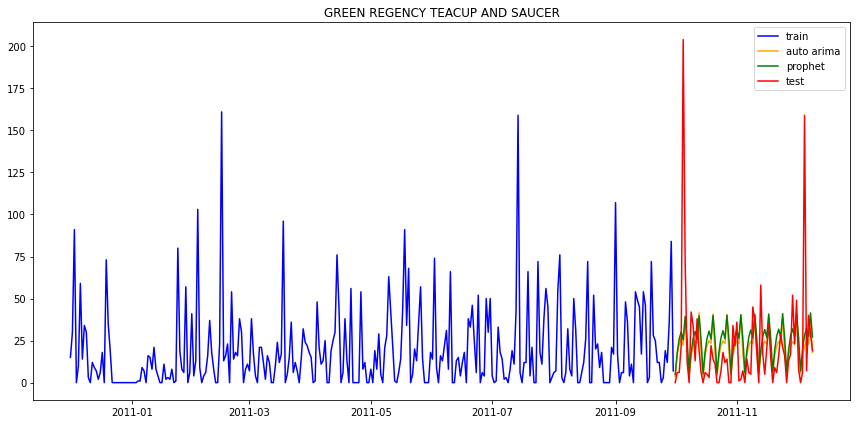

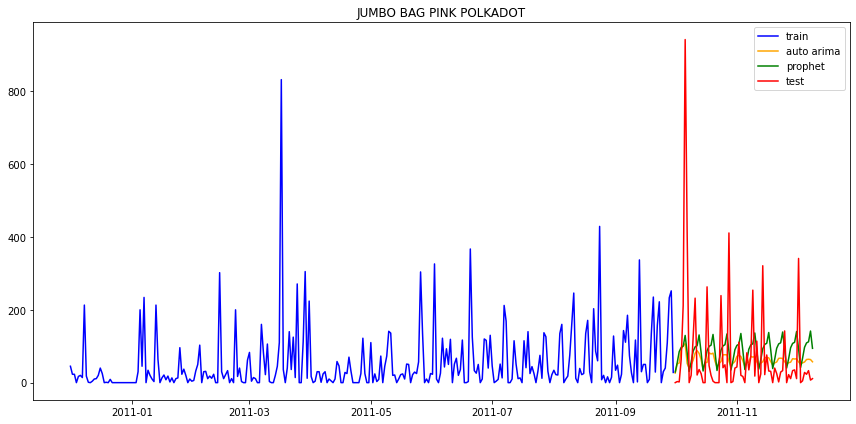

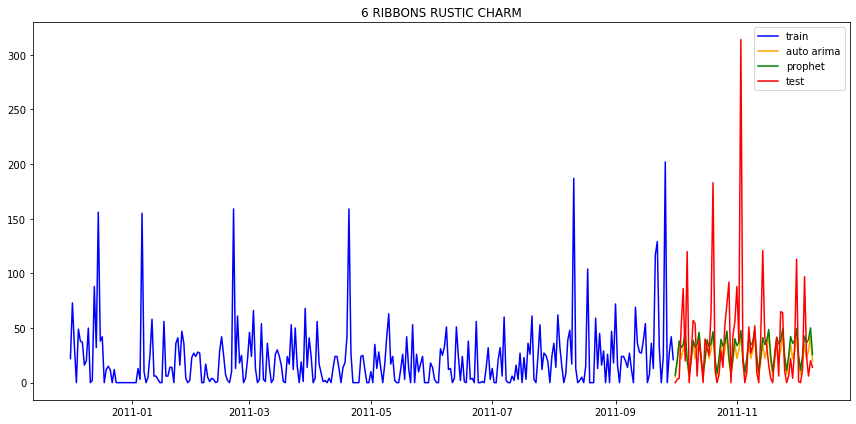

In [49]:
plot_models()

In [50]:
real_data=pd.DataFrame()
def train_output():
    for i in final_products:
        data=date_stock.loc[i][['Quantity']]

        name=df.loc[df['StockCode']==i]['Description'].iloc[0]
        # set the frequency to daily
        data=data.asfreq('D')

        #train set
        train=data.loc['2010-12-01':'2011-12-09']

        real_data[name]=train.reset_index()['Quantity']

train_output()
index=date_stock.loc[final_products[1]][['Quantity']].index
real_data.set_index(index,inplace=True)

In [51]:
# full data from 2010-12-01 to 2011-12-09
real_data.to_csv('full_data.csv')
real_data

,WHITE HANGING HEART T-LIGHT HOLDER,JUMBO BAG RED RETROSPOT,REGENCY CAKESTAND 3 TIER,ASSORTED COLOUR BIRD ORNAMENT,LUNCH BAG RED RETROSPOT,PACK OF 72 RETROSPOT CAKE CASES,NATURAL SLATE HEART CHALKBOARD,JAM MAKING SET WITH JARS,SMALL POPCORN HOLDER,RECIPE BOX PANTRY YELLOW DESIGN,LUNCH BAG CARS BLUE,WOODEN PICTURE FRAME WHITE FINISH,LUNCH BAG PINK POLKADOT,LUNCH BAG BLACK SKULL.,ALARM CLOCK BAKELIKE RED,VICTORIAN GLASS HANGING T-LIGHT,JUMBO STORAGE BAG SUKI,GREEN REGENCY TEACUP AND SAUCER,JUMBO BAG PINK POLKADOT,6 RIBBONS RUSTIC CHARM
InvoiceDate,,,,,,,,,,,,,,,,,,,,
2010-12-01,454,556,115,224,78,241,38,65,271,28,22,24,4,145,47,69,54,15,45,22
2010-12-02,309,48,184,503,11,459,28,38,74,13,3,72,14,34,88,24,14,30,23,73
2010-12-03,25,49,231,48,93,254,28,13,67,4,122,1,104,67,51,14,43,91,23,33
2010-12-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2010-12-05,198,39,92,129,36,21,25,23,81,79,28,39,2,12,42,0,9,10,17,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-05,298,66,36,133,50,42,59,30,410,61,11,15,30,24,127,377,44,159,28,97
2011-12-06,39,175,160,240,85,90,13,80,337,257,25,8,15,63,37,74,47,7,23,24
2011-12-07,200,89,130,256,35,74,660,60,368,21,28,42,40,40,673,78,46,40,33,6


### Load the pickle files and visualize them with the prophet library plots

In [52]:
def load_plot_pickle():
    """
    This function loads the pickle files 
    and plot each trained pickle file on the test set
    
    """
    
    for i in final_products:

        name=df.loc[df['StockCode']==i]['Description'].iloc[0]
        with open(f'/Users/raminstad/Downloads/Data Scientist Test/pickle_models/{name}' , 'rb') as f:
            model_i= pickle.load(f)
            
        data=date_stock.loc[i][['Quantity']]
        data=data.asfreq('D')

        
        test=data.loc['2011-10-01':'2011-12-09']
        index=pd.DataFrame(test.index)
        index.columns=['ds']
        index['ds']=pd.to_datetime(index['ds'])
        fcasts=model_i.predict(index)

        model_i.plot(fcasts)

        plt.title(name)
        plt.ylabel('Quantity')
        plt.xlabel('Date')
        plt.tight_layout()
        plt.show()


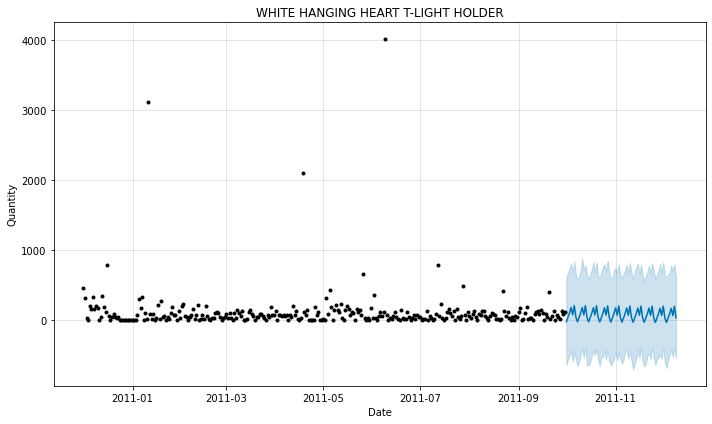

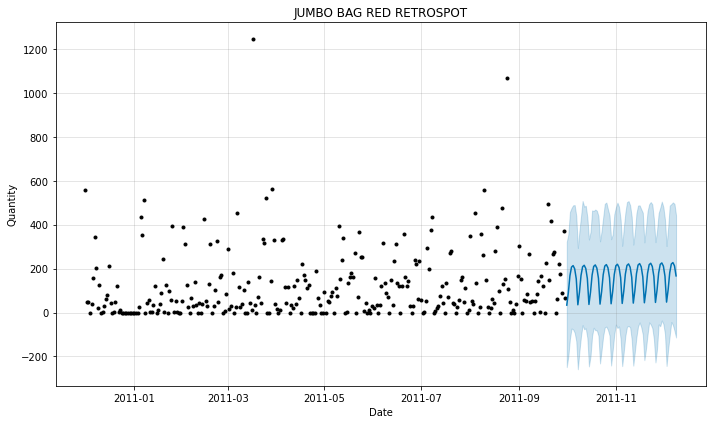

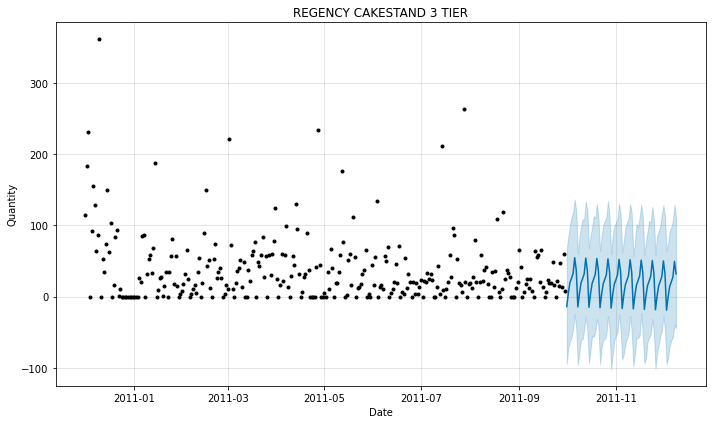

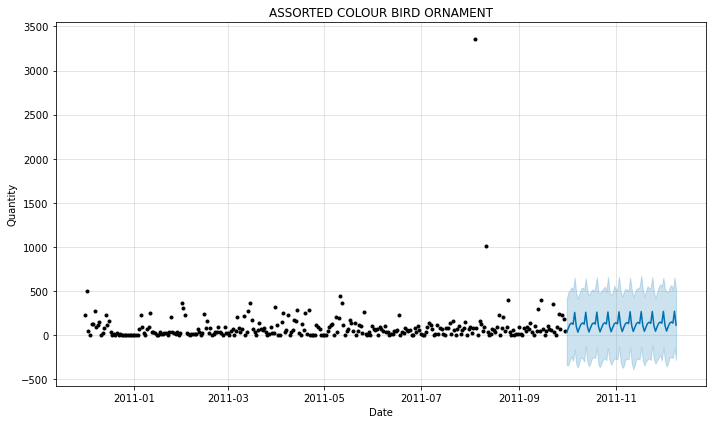

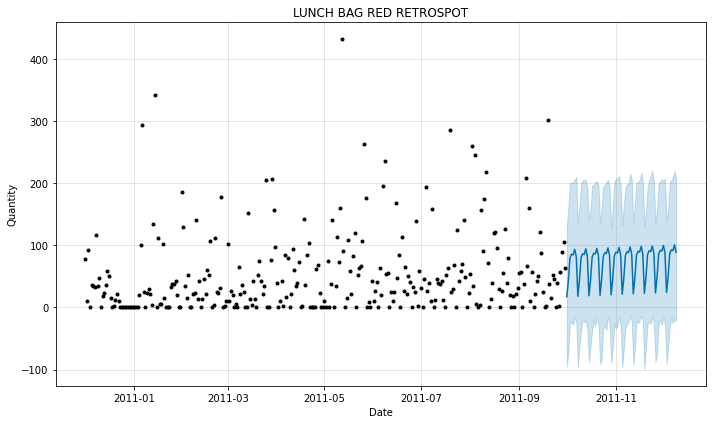

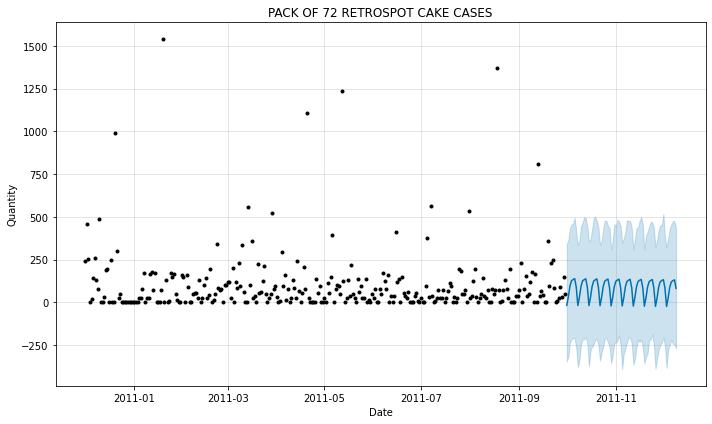

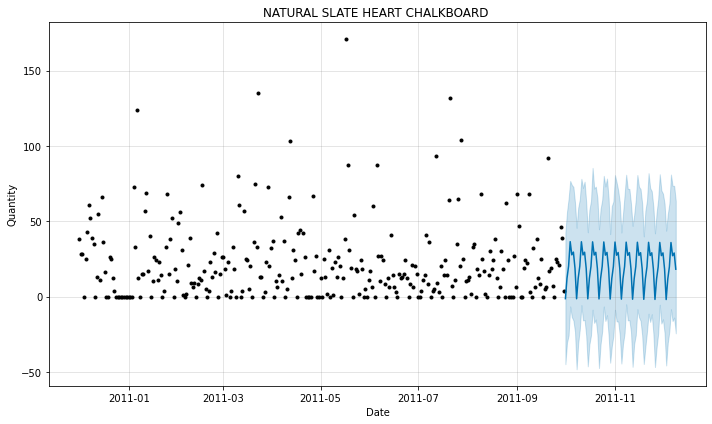

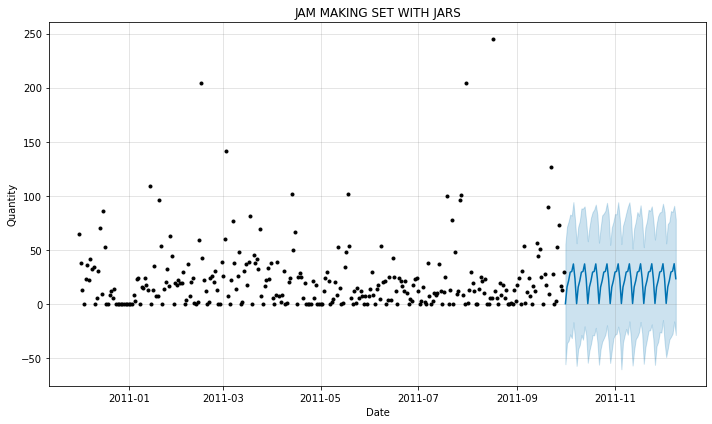

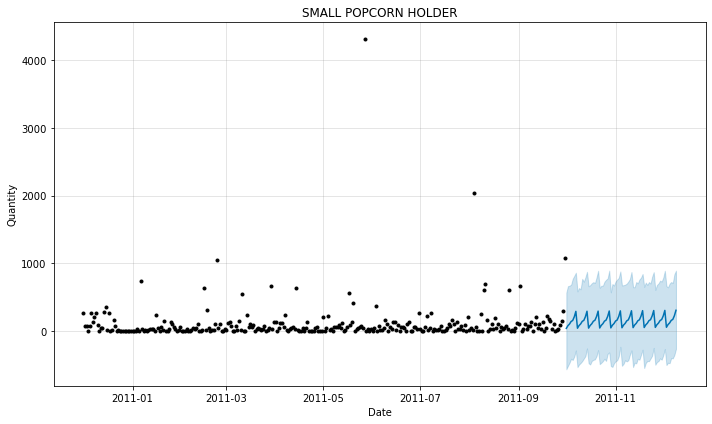

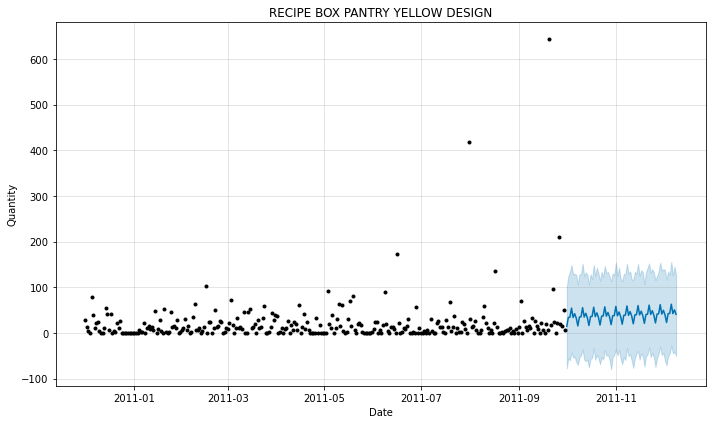

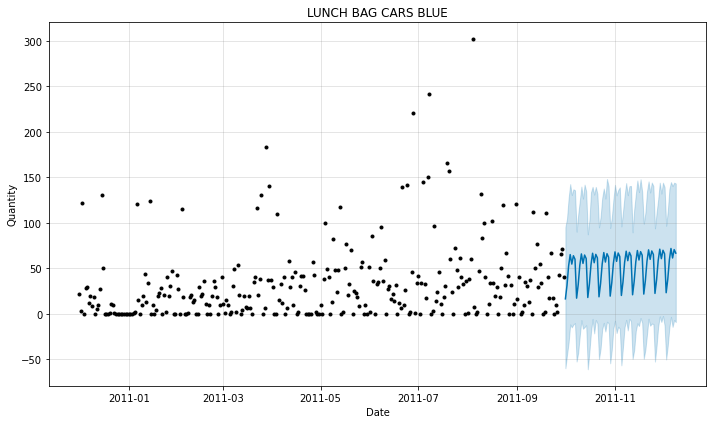

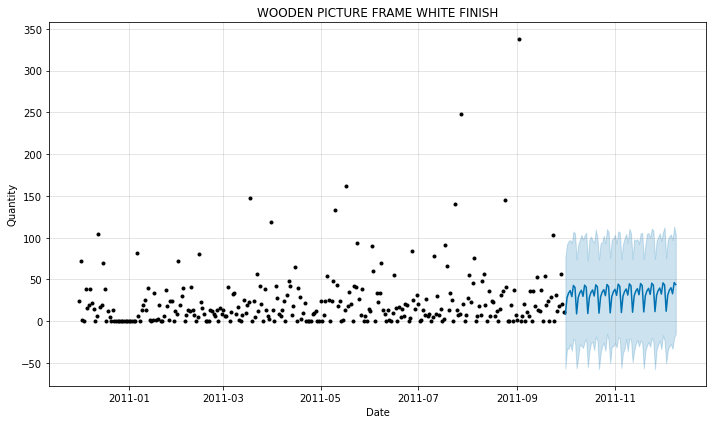

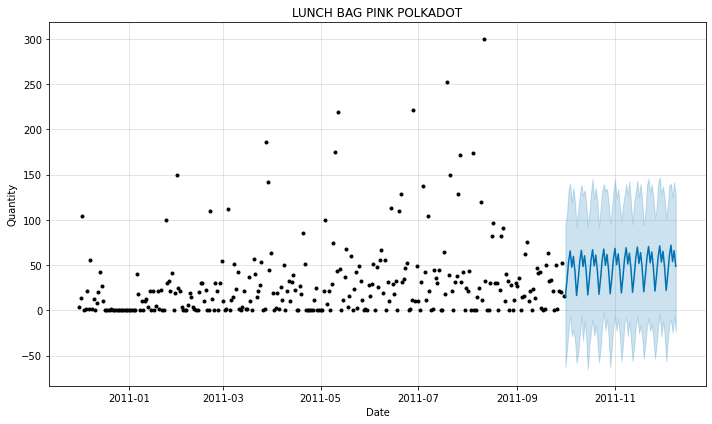

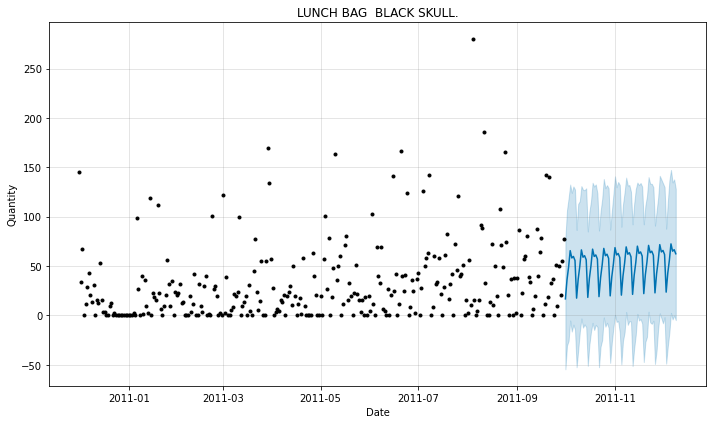

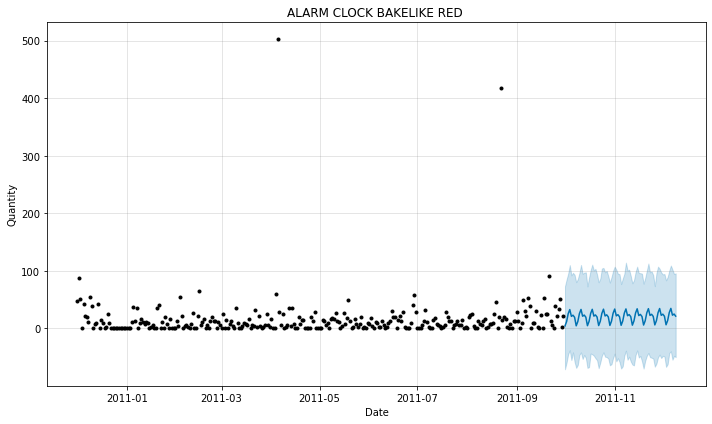

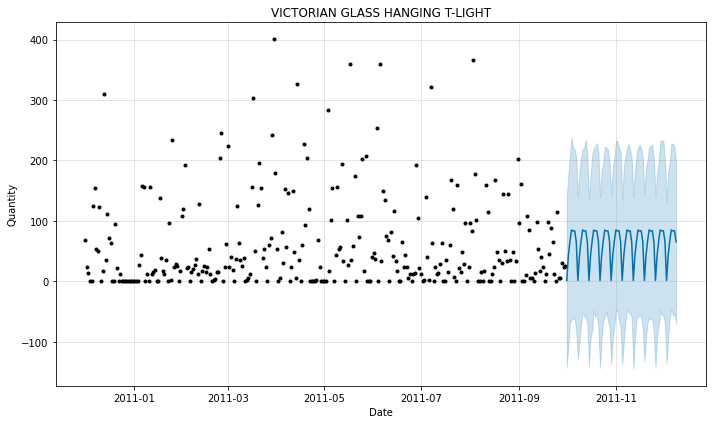

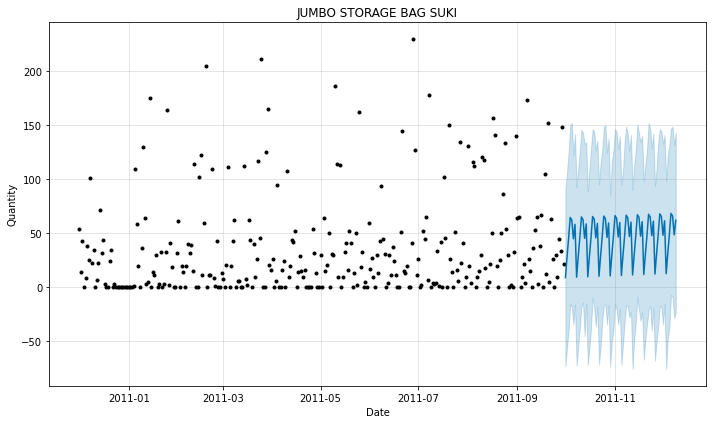

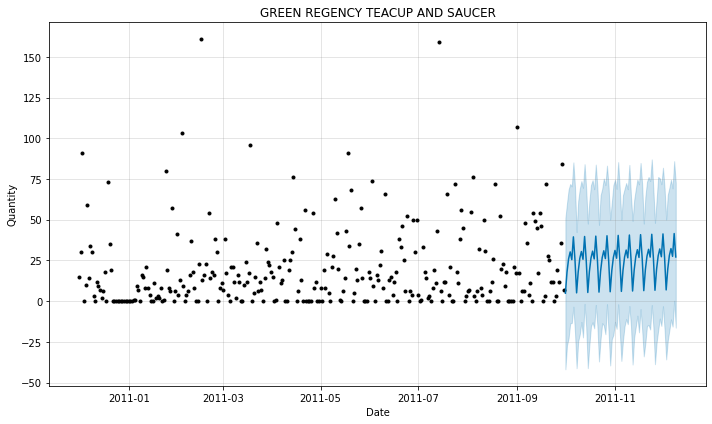

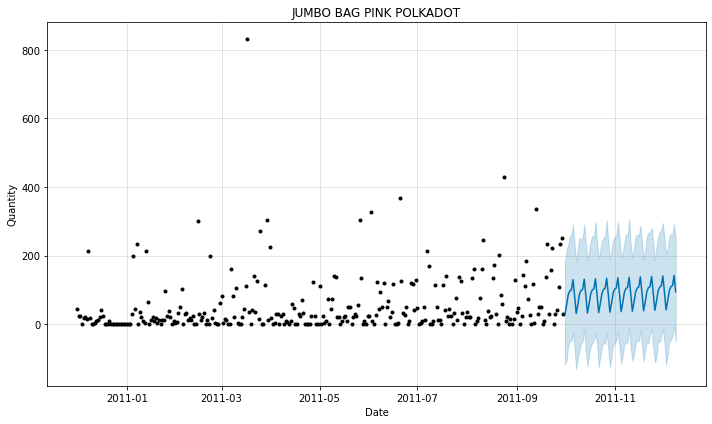

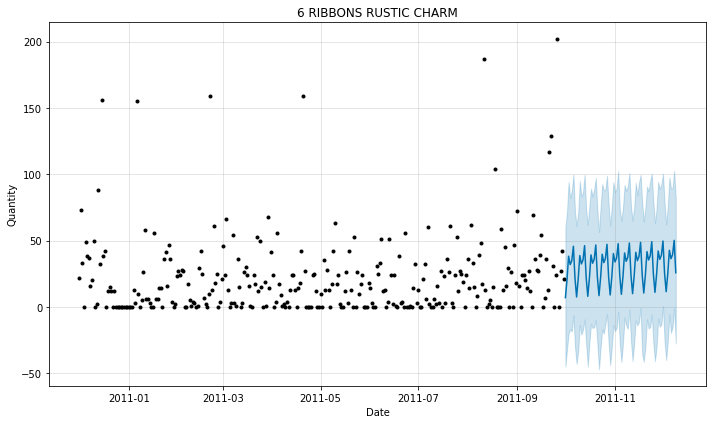

In [53]:
load_plot_pickle()